# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

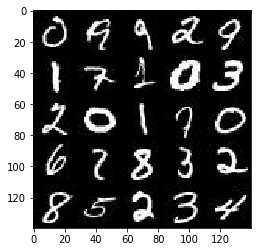

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

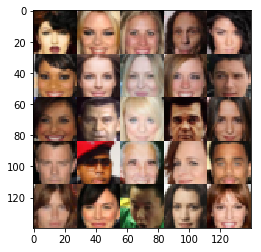

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, None)
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xchannel
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # calculate losses
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get weights and bias to update    
    t_vars = tf.trainable_variables()
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    height, width, channel = data_shape[1:]
    
    input_real, input_z, lr = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    smooth = 0.1
    
    # determine how often to show sample image and print trainging stat
    print_per_epoch = 100
    show_per_epoch = 5
    total_samples = data_shape[0]
    total_batch_in_epoch = total_samples // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for ii, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                
                # normalize input
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if ii > 0 and ii % (total_batch_in_epoch // print_per_epoch) == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = sess.run(g_loss, {input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "{:.2f}%...".format(ii * 100.0 / total_batch_in_epoch),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                if ii > 0 and ii % (total_batch_in_epoch // show_per_epoch) == 0:
                    show_generator_output(sess, 16, tf.random_uniform((16, z_dim)), channel, data_image_mode)

    print('finished training...')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... 0.85%... Discriminator Loss: 0.7140... Generator Loss: 2.7956
Epoch 1/2... 1.71%... Discriminator Loss: 0.4536... Generator Loss: 1.4951
Epoch 1/2... 2.56%... Discriminator Loss: 0.6404... Generator Loss: 4.5818
Epoch 1/2... 3.42%... Discriminator Loss: 0.1449... Generator Loss: 4.7289
Epoch 1/2... 4.27%... Discriminator Loss: 0.0813... Generator Loss: 3.9238
Epoch 1/2... 5.13%... Discriminator Loss: 0.1494... Generator Loss: 2.1792
Epoch 1/2... 5.98%... Discriminator Loss: 0.0154... Generator Loss: 5.9901
Epoch 1/2... 6.84%... Discriminator Loss: 0.0180... Generator Loss: 4.6574
Epoch 1/2... 7.69%... Discriminator Loss: 0.0211... Generator Loss: 4.5593
Epoch 1/2... 8.55%... Discriminator Loss: 0.0186... Generator Loss: 5.0976
Epoch 1/2... 9.40%... Discriminator Loss: 0.0195... Generator Loss: 5.0618
Epoch 1/2... 10.26%... Discriminator Loss: 0.6480... Generator Loss: 7.2252
Epoch 1/2... 11.11%... Discriminator Loss: 0.1849... Generator Loss: 7.2166
Epoch 1/2... 11.97%... 

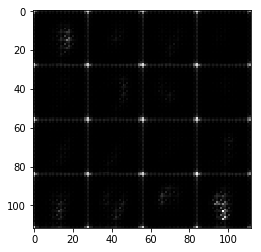

Epoch 1/2... 20.51%... Discriminator Loss: 1.1365... Generator Loss: 0.9548
Epoch 1/2... 21.37%... Discriminator Loss: 0.2829... Generator Loss: 2.9793
Epoch 1/2... 22.22%... Discriminator Loss: 0.7360... Generator Loss: 2.0427
Epoch 1/2... 23.08%... Discriminator Loss: 0.6405... Generator Loss: 1.7278
Epoch 1/2... 23.93%... Discriminator Loss: 0.3864... Generator Loss: 1.8075
Epoch 1/2... 24.79%... Discriminator Loss: 0.2469... Generator Loss: 2.8103
Epoch 1/2... 25.64%... Discriminator Loss: 0.2585... Generator Loss: 2.5364
Epoch 1/2... 26.50%... Discriminator Loss: 0.3577... Generator Loss: 2.3358
Epoch 1/2... 27.35%... Discriminator Loss: 0.5458... Generator Loss: 2.0718
Epoch 1/2... 28.21%... Discriminator Loss: 0.2770... Generator Loss: 2.6146
Epoch 1/2... 29.06%... Discriminator Loss: 0.3988... Generator Loss: 2.0119
Epoch 1/2... 29.91%... Discriminator Loss: 0.6060... Generator Loss: 1.6720
Epoch 1/2... 30.77%... Discriminator Loss: 0.6254... Generator Loss: 1.7317
Epoch 1/2...

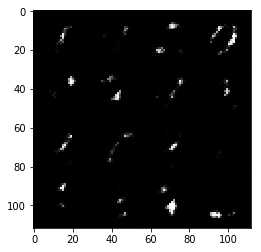

Epoch 1/2... 40.17%... Discriminator Loss: 0.3873... Generator Loss: 2.4108
Epoch 1/2... 41.03%... Discriminator Loss: 0.6528... Generator Loss: 2.3454
Epoch 1/2... 41.88%... Discriminator Loss: 0.8225... Generator Loss: 1.3291
Epoch 1/2... 42.74%... Discriminator Loss: 0.5259... Generator Loss: 1.5328
Epoch 1/2... 43.59%... Discriminator Loss: 0.3353... Generator Loss: 2.2741
Epoch 1/2... 44.44%... Discriminator Loss: 0.5437... Generator Loss: 2.1213
Epoch 1/2... 45.30%... Discriminator Loss: 0.7138... Generator Loss: 1.5595
Epoch 1/2... 46.15%... Discriminator Loss: 0.9937... Generator Loss: 3.4806
Epoch 1/2... 47.01%... Discriminator Loss: 0.5222... Generator Loss: 1.3238
Epoch 1/2... 47.86%... Discriminator Loss: 0.8440... Generator Loss: 0.9746
Epoch 1/2... 48.72%... Discriminator Loss: 0.4697... Generator Loss: 2.2150
Epoch 1/2... 49.57%... Discriminator Loss: 0.5953... Generator Loss: 1.6772
Epoch 1/2... 50.43%... Discriminator Loss: 1.2016... Generator Loss: 0.5572
Epoch 1/2...

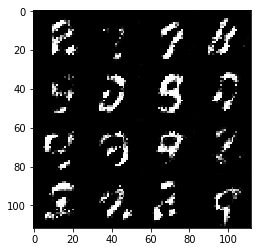

Epoch 1/2... 59.83%... Discriminator Loss: 0.2712... Generator Loss: 2.4590
Epoch 1/2... 60.68%... Discriminator Loss: 0.3879... Generator Loss: 2.5436
Epoch 1/2... 61.54%... Discriminator Loss: 0.3509... Generator Loss: 2.2629
Epoch 1/2... 62.39%... Discriminator Loss: 0.3655... Generator Loss: 1.9503
Epoch 1/2... 63.25%... Discriminator Loss: 0.2563... Generator Loss: 2.4433
Epoch 1/2... 64.10%... Discriminator Loss: 0.4960... Generator Loss: 1.4240
Epoch 1/2... 64.96%... Discriminator Loss: 2.2886... Generator Loss: 0.1860
Epoch 1/2... 65.81%... Discriminator Loss: 0.5197... Generator Loss: 1.9949
Epoch 1/2... 66.67%... Discriminator Loss: 0.7682... Generator Loss: 2.0672
Epoch 1/2... 67.52%... Discriminator Loss: 0.8280... Generator Loss: 1.2900
Epoch 1/2... 68.38%... Discriminator Loss: 0.7700... Generator Loss: 1.4346
Epoch 1/2... 69.23%... Discriminator Loss: 1.2146... Generator Loss: 1.5293
Epoch 1/2... 70.09%... Discriminator Loss: 1.7920... Generator Loss: 0.4834
Epoch 1/2...

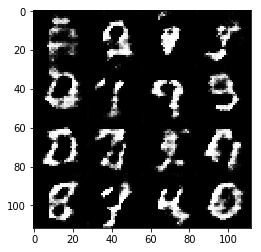

Epoch 1/2... 80.34%... Discriminator Loss: 0.6794... Generator Loss: 1.4330
Epoch 1/2... 81.20%... Discriminator Loss: 0.8772... Generator Loss: 1.1014
Epoch 1/2... 82.05%... Discriminator Loss: 1.1245... Generator Loss: 1.2552
Epoch 1/2... 82.91%... Discriminator Loss: 1.0067... Generator Loss: 1.7826
Epoch 1/2... 83.76%... Discriminator Loss: 0.8302... Generator Loss: 1.6323
Epoch 1/2... 84.62%... Discriminator Loss: 0.7293... Generator Loss: 1.3400
Epoch 1/2... 85.47%... Discriminator Loss: 0.8300... Generator Loss: 1.6833
Epoch 1/2... 86.32%... Discriminator Loss: 0.7746... Generator Loss: 1.1774
Epoch 1/2... 87.18%... Discriminator Loss: 0.8326... Generator Loss: 1.3709
Epoch 1/2... 88.03%... Discriminator Loss: 0.7304... Generator Loss: 1.6621
Epoch 1/2... 88.89%... Discriminator Loss: 0.9537... Generator Loss: 1.1618
Epoch 1/2... 89.74%... Discriminator Loss: 0.7350... Generator Loss: 1.7962
Epoch 1/2... 90.60%... Discriminator Loss: 0.6134... Generator Loss: 1.8771
Epoch 1/2...

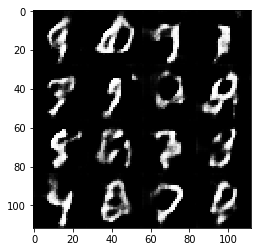

Epoch 2/2... 0.85%... Discriminator Loss: 1.0555... Generator Loss: 0.6738
Epoch 2/2... 1.71%... Discriminator Loss: 0.7904... Generator Loss: 2.1626
Epoch 2/2... 2.56%... Discriminator Loss: 0.6518... Generator Loss: 1.5081
Epoch 2/2... 3.42%... Discriminator Loss: 0.8608... Generator Loss: 1.0177
Epoch 2/2... 4.27%... Discriminator Loss: 0.7686... Generator Loss: 1.3243
Epoch 2/2... 5.13%... Discriminator Loss: 0.5626... Generator Loss: 1.4491
Epoch 2/2... 5.98%... Discriminator Loss: 0.7047... Generator Loss: 1.9382
Epoch 2/2... 6.84%... Discriminator Loss: 0.7240... Generator Loss: 1.2312
Epoch 2/2... 7.69%... Discriminator Loss: 0.8264... Generator Loss: 1.8129
Epoch 2/2... 8.55%... Discriminator Loss: 1.1019... Generator Loss: 2.3398
Epoch 2/2... 9.40%... Discriminator Loss: 0.6126... Generator Loss: 1.7304
Epoch 2/2... 10.26%... Discriminator Loss: 0.7265... Generator Loss: 1.1755
Epoch 2/2... 11.11%... Discriminator Loss: 0.7063... Generator Loss: 1.1265
Epoch 2/2... 11.97%... 

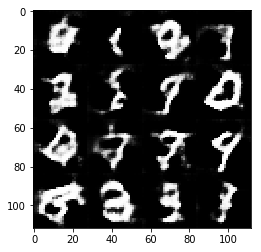

Epoch 2/2... 20.51%... Discriminator Loss: 0.6064... Generator Loss: 1.5765
Epoch 2/2... 21.37%... Discriminator Loss: 0.6939... Generator Loss: 1.4669
Epoch 2/2... 22.22%... Discriminator Loss: 0.7561... Generator Loss: 1.2561
Epoch 2/2... 23.08%... Discriminator Loss: 0.8478... Generator Loss: 1.1679
Epoch 2/2... 23.93%... Discriminator Loss: 0.8010... Generator Loss: 1.4522
Epoch 2/2... 24.79%... Discriminator Loss: 0.8009... Generator Loss: 1.0897
Epoch 2/2... 25.64%... Discriminator Loss: 0.5968... Generator Loss: 1.8992
Epoch 2/2... 26.50%... Discriminator Loss: 0.8407... Generator Loss: 1.1383
Epoch 2/2... 27.35%... Discriminator Loss: 0.7267... Generator Loss: 1.2461
Epoch 2/2... 28.21%... Discriminator Loss: 0.7727... Generator Loss: 1.1615
Epoch 2/2... 29.06%... Discriminator Loss: 0.7349... Generator Loss: 1.3285
Epoch 2/2... 29.91%... Discriminator Loss: 0.7736... Generator Loss: 1.5383
Epoch 2/2... 30.77%... Discriminator Loss: 0.6860... Generator Loss: 1.3784
Epoch 2/2...

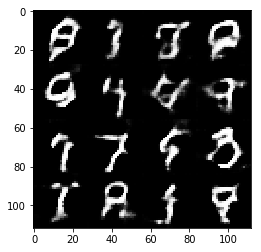

Epoch 2/2... 40.17%... Discriminator Loss: 0.9274... Generator Loss: 1.0251
Epoch 2/2... 41.03%... Discriminator Loss: 0.9165... Generator Loss: 1.2859
Epoch 2/2... 41.88%... Discriminator Loss: 0.6879... Generator Loss: 1.6375
Epoch 2/2... 42.74%... Discriminator Loss: 0.7214... Generator Loss: 1.6335
Epoch 2/2... 43.59%... Discriminator Loss: 0.7897... Generator Loss: 1.4352
Epoch 2/2... 44.44%... Discriminator Loss: 1.0903... Generator Loss: 2.4209
Epoch 2/2... 45.30%... Discriminator Loss: 0.7444... Generator Loss: 1.6132
Epoch 2/2... 46.15%... Discriminator Loss: 0.6953... Generator Loss: 1.3633
Epoch 2/2... 47.01%... Discriminator Loss: 0.9833... Generator Loss: 1.4751
Epoch 2/2... 47.86%... Discriminator Loss: 0.8513... Generator Loss: 1.3670
Epoch 2/2... 48.72%... Discriminator Loss: 0.6190... Generator Loss: 1.7405
Epoch 2/2... 49.57%... Discriminator Loss: 0.8603... Generator Loss: 1.1911
Epoch 2/2... 50.43%... Discriminator Loss: 0.7069... Generator Loss: 1.3623
Epoch 2/2...

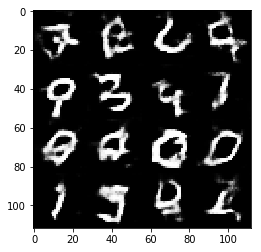

Epoch 2/2... 59.83%... Discriminator Loss: 0.7111... Generator Loss: 1.6604
Epoch 2/2... 60.68%... Discriminator Loss: 0.9228... Generator Loss: 0.9991
Epoch 2/2... 61.54%... Discriminator Loss: 0.8617... Generator Loss: 1.7913
Epoch 2/2... 62.39%... Discriminator Loss: 0.5990... Generator Loss: 1.3463
Epoch 2/2... 63.25%... Discriminator Loss: 0.6744... Generator Loss: 1.6764
Epoch 2/2... 64.10%... Discriminator Loss: 0.8304... Generator Loss: 1.1862
Epoch 2/2... 64.96%... Discriminator Loss: 0.9409... Generator Loss: 0.8022
Epoch 2/2... 65.81%... Discriminator Loss: 0.6661... Generator Loss: 1.7478
Epoch 2/2... 66.67%... Discriminator Loss: 0.7569... Generator Loss: 1.2883
Epoch 2/2... 67.52%... Discriminator Loss: 0.7077... Generator Loss: 1.2852
Epoch 2/2... 68.38%... Discriminator Loss: 0.7071... Generator Loss: 1.4562
Epoch 2/2... 69.23%... Discriminator Loss: 0.6287... Generator Loss: 1.7356
Epoch 2/2... 70.09%... Discriminator Loss: 0.7814... Generator Loss: 1.6792
Epoch 2/2...

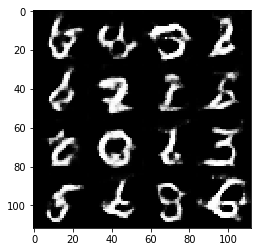

Epoch 2/2... 80.34%... Discriminator Loss: 0.6201... Generator Loss: 1.6164
Epoch 2/2... 81.20%... Discriminator Loss: 0.6623... Generator Loss: 1.5302
Epoch 2/2... 82.05%... Discriminator Loss: 0.6464... Generator Loss: 1.3220
Epoch 2/2... 82.91%... Discriminator Loss: 0.6159... Generator Loss: 1.4858
Epoch 2/2... 83.76%... Discriminator Loss: 0.5634... Generator Loss: 1.8777
Epoch 2/2... 84.62%... Discriminator Loss: 0.7013... Generator Loss: 1.0243
Epoch 2/2... 85.47%... Discriminator Loss: 0.6330... Generator Loss: 1.4597
Epoch 2/2... 86.32%... Discriminator Loss: 0.5439... Generator Loss: 1.5422
Epoch 2/2... 87.18%... Discriminator Loss: 0.7100... Generator Loss: 1.4393
Epoch 2/2... 88.03%... Discriminator Loss: 0.7330... Generator Loss: 1.0406
Epoch 2/2... 88.89%... Discriminator Loss: 0.5739... Generator Loss: 1.4229
Epoch 2/2... 89.74%... Discriminator Loss: 0.6053... Generator Loss: 1.4511
Epoch 2/2... 90.60%... Discriminator Loss: 0.6157... Generator Loss: 1.8379
Epoch 2/2...

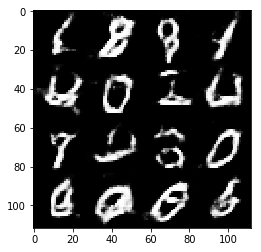

finished training...


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/10... 0.95%... Discriminator Loss: 0.0666... Generator Loss: 3.5413
Epoch 1/10... 1.90%... Discriminator Loss: 0.1241... Generator Loss: 3.7346
Epoch 1/10... 2.84%... Discriminator Loss: 0.0192... Generator Loss: 5.8000
Epoch 1/10... 3.79%... Discriminator Loss: 0.0873... Generator Loss: 5.7437
Epoch 1/10... 4.74%... Discriminator Loss: 0.1209... Generator Loss: 3.1507
Epoch 1/10... 5.69%... Discriminator Loss: 0.5549... Generator Loss: 2.8588
Epoch 1/10... 6.64%... Discriminator Loss: 0.3794... Generator Loss: 2.0532
Epoch 1/10... 7.59%... Discriminator Loss: 0.2968... Generator Loss: 1.9958
Epoch 1/10... 8.53%... Discriminator Loss: 0.2338... Generator Loss: 2.9510
Epoch 1/10... 9.48%... Discriminator Loss: 0.0779... Generator Loss: 4.0730
Epoch 1/10... 10.43%... Discriminator Loss: 0.0675... Generator Loss: 3.8803
Epoch 1/10... 11.38%... Discriminator Loss: 0.0484... Generator Loss: 6.5111
Epoch 1/10... 12.33%... Discriminator Loss: 0.0257... Generator Loss: 5.6655
Epoch 1/1

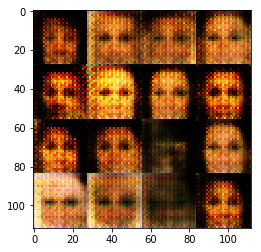

Epoch 1/10... 20.86%... Discriminator Loss: 0.1739... Generator Loss: 3.3937
Epoch 1/10... 21.81%... Discriminator Loss: 0.3429... Generator Loss: 2.5362
Epoch 1/10... 22.76%... Discriminator Loss: 0.9109... Generator Loss: 1.4523
Epoch 1/10... 23.70%... Discriminator Loss: 1.3619... Generator Loss: 0.9794
Epoch 1/10... 24.65%... Discriminator Loss: 0.5215... Generator Loss: 2.2843
Epoch 1/10... 25.60%... Discriminator Loss: 0.3876... Generator Loss: 1.9066
Epoch 1/10... 26.55%... Discriminator Loss: 1.3336... Generator Loss: 1.0793
Epoch 1/10... 27.50%... Discriminator Loss: 0.8820... Generator Loss: 1.0474
Epoch 1/10... 28.45%... Discriminator Loss: 0.8837... Generator Loss: 1.3491
Epoch 1/10... 29.39%... Discriminator Loss: 0.1856... Generator Loss: 2.7127
Epoch 1/10... 30.34%... Discriminator Loss: 0.3461... Generator Loss: 2.1580
Epoch 1/10... 31.29%... Discriminator Loss: 0.7999... Generator Loss: 1.8339
Epoch 1/10... 32.24%... Discriminator Loss: 0.6763... Generator Loss: 1.4543

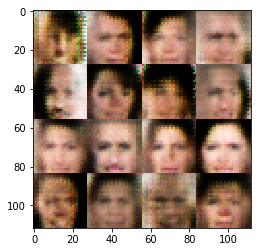

Epoch 1/10... 40.77%... Discriminator Loss: 1.0959... Generator Loss: 1.3211
Epoch 1/10... 41.72%... Discriminator Loss: 0.7890... Generator Loss: 1.5118
Epoch 1/10... 42.67%... Discriminator Loss: 1.5349... Generator Loss: 0.9002
Epoch 1/10... 43.62%... Discriminator Loss: 1.0037... Generator Loss: 0.9773
Epoch 1/10... 44.56%... Discriminator Loss: 1.2425... Generator Loss: 1.0624
Epoch 1/10... 45.51%... Discriminator Loss: 0.8171... Generator Loss: 1.1466
Epoch 1/10... 46.46%... Discriminator Loss: 1.2114... Generator Loss: 0.8166
Epoch 1/10... 47.41%... Discriminator Loss: 1.0569... Generator Loss: 0.9697
Epoch 1/10... 48.36%... Discriminator Loss: 1.0332... Generator Loss: 1.0795
Epoch 1/10... 49.30%... Discriminator Loss: 1.3972... Generator Loss: 1.1581
Epoch 1/10... 50.25%... Discriminator Loss: 0.9992... Generator Loss: 0.9210
Epoch 1/10... 51.20%... Discriminator Loss: 1.0895... Generator Loss: 1.1515
Epoch 1/10... 52.15%... Discriminator Loss: 1.0100... Generator Loss: 1.2865

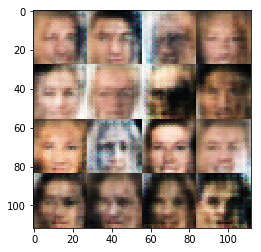

Epoch 1/10... 60.68%... Discriminator Loss: 1.1392... Generator Loss: 0.8988
Epoch 1/10... 61.63%... Discriminator Loss: 1.4175... Generator Loss: 0.7538
Epoch 1/10... 62.58%... Discriminator Loss: 1.2359... Generator Loss: 0.8902
Epoch 1/10... 63.53%... Discriminator Loss: 1.2146... Generator Loss: 0.9590
Epoch 1/10... 64.48%... Discriminator Loss: 1.0473... Generator Loss: 0.9717
Epoch 1/10... 65.42%... Discriminator Loss: 1.2295... Generator Loss: 0.9892
Epoch 1/10... 66.37%... Discriminator Loss: 1.2539... Generator Loss: 0.9958
Epoch 1/10... 67.32%... Discriminator Loss: 1.2176... Generator Loss: 1.0350
Epoch 1/10... 68.27%... Discriminator Loss: 1.0545... Generator Loss: 0.9639
Epoch 1/10... 69.22%... Discriminator Loss: 1.0529... Generator Loss: 1.0745
Epoch 1/10... 70.16%... Discriminator Loss: 1.0870... Generator Loss: 1.4155
Epoch 1/10... 71.11%... Discriminator Loss: 1.0606... Generator Loss: 1.2231
Epoch 1/10... 72.06%... Discriminator Loss: 1.1736... Generator Loss: 0.9252

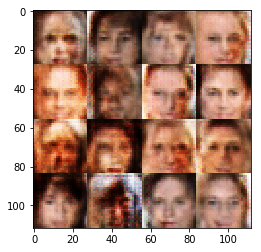

Epoch 1/10... 80.59%... Discriminator Loss: 1.2377... Generator Loss: 0.8413
Epoch 1/10... 81.54%... Discriminator Loss: 1.0500... Generator Loss: 1.0522
Epoch 1/10... 82.49%... Discriminator Loss: 0.7791... Generator Loss: 1.2807
Epoch 1/10... 83.44%... Discriminator Loss: 0.4925... Generator Loss: 1.8275
Epoch 1/10... 84.39%... Discriminator Loss: 0.8370... Generator Loss: 0.9732
Epoch 1/10... 85.34%... Discriminator Loss: 1.1570... Generator Loss: 0.7946
Epoch 1/10... 86.28%... Discriminator Loss: 1.1384... Generator Loss: 0.8792
Epoch 1/10... 87.23%... Discriminator Loss: 1.1341... Generator Loss: 0.9687
Epoch 1/10... 88.18%... Discriminator Loss: 1.0335... Generator Loss: 0.9133
Epoch 1/10... 89.13%... Discriminator Loss: 1.2215... Generator Loss: 0.5824
Epoch 1/10... 90.08%... Discriminator Loss: 1.2216... Generator Loss: 0.9083
Epoch 1/10... 91.02%... Discriminator Loss: 1.0850... Generator Loss: 1.2354
Epoch 1/10... 91.97%... Discriminator Loss: 0.9491... Generator Loss: 1.2907

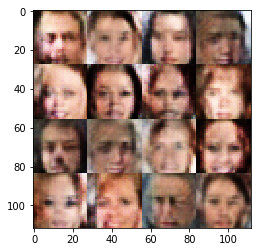

Epoch 2/10... 0.95%... Discriminator Loss: 1.5319... Generator Loss: 0.4856
Epoch 2/10... 1.90%... Discriminator Loss: 1.5382... Generator Loss: 0.4175
Epoch 2/10... 2.84%... Discriminator Loss: 0.9934... Generator Loss: 0.8909
Epoch 2/10... 3.79%... Discriminator Loss: 1.3904... Generator Loss: 0.7838
Epoch 2/10... 4.74%... Discriminator Loss: 0.7324... Generator Loss: 0.9668
Epoch 2/10... 5.69%... Discriminator Loss: 0.9953... Generator Loss: 0.9818
Epoch 2/10... 6.64%... Discriminator Loss: 0.6885... Generator Loss: 1.2158
Epoch 2/10... 7.59%... Discriminator Loss: 1.2610... Generator Loss: 0.5472
Epoch 2/10... 8.53%... Discriminator Loss: 1.2447... Generator Loss: 0.5499
Epoch 2/10... 9.48%... Discriminator Loss: 0.8543... Generator Loss: 1.1504
Epoch 2/10... 10.43%... Discriminator Loss: 0.9571... Generator Loss: 1.2650
Epoch 2/10... 11.38%... Discriminator Loss: 1.4458... Generator Loss: 1.5334
Epoch 2/10... 12.33%... Discriminator Loss: 0.6045... Generator Loss: 1.3191
Epoch 2/1

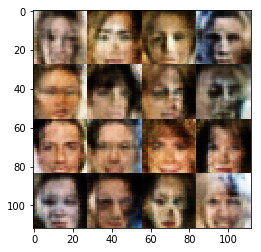

Epoch 2/10... 20.86%... Discriminator Loss: 1.0074... Generator Loss: 1.1227
Epoch 2/10... 21.81%... Discriminator Loss: 1.2109... Generator Loss: 0.7265
Epoch 2/10... 22.76%... Discriminator Loss: 1.3418... Generator Loss: 0.6955
Epoch 2/10... 23.70%... Discriminator Loss: 1.2704... Generator Loss: 1.0742
Epoch 2/10... 24.65%... Discriminator Loss: 0.8260... Generator Loss: 1.2321
Epoch 2/10... 25.60%... Discriminator Loss: 1.1228... Generator Loss: 1.5035
Epoch 2/10... 26.55%... Discriminator Loss: 0.7313... Generator Loss: 1.4914
Epoch 2/10... 27.50%... Discriminator Loss: 1.0817... Generator Loss: 0.9383
Epoch 2/10... 28.45%... Discriminator Loss: 1.3448... Generator Loss: 0.9593
Epoch 2/10... 29.39%... Discriminator Loss: 0.9144... Generator Loss: 1.0400
Epoch 2/10... 30.34%... Discriminator Loss: 1.0203... Generator Loss: 0.9464
Epoch 2/10... 31.29%... Discriminator Loss: 1.0235... Generator Loss: 0.9773
Epoch 2/10... 32.24%... Discriminator Loss: 1.2313... Generator Loss: 0.5004

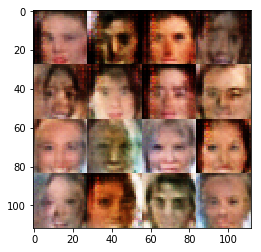

Epoch 2/10... 40.77%... Discriminator Loss: 0.8938... Generator Loss: 1.1767
Epoch 2/10... 41.72%... Discriminator Loss: 1.0127... Generator Loss: 0.9377
Epoch 2/10... 42.67%... Discriminator Loss: 0.9181... Generator Loss: 1.3997
Epoch 2/10... 43.62%... Discriminator Loss: 0.9244... Generator Loss: 0.7495
Epoch 2/10... 44.56%... Discriminator Loss: 1.2101... Generator Loss: 1.8770
Epoch 2/10... 45.51%... Discriminator Loss: 1.3672... Generator Loss: 0.5339
Epoch 2/10... 46.46%... Discriminator Loss: 1.5147... Generator Loss: 0.3754
Epoch 2/10... 47.41%... Discriminator Loss: 1.2079... Generator Loss: 0.7855
Epoch 2/10... 48.36%... Discriminator Loss: 0.5296... Generator Loss: 1.9898
Epoch 2/10... 49.30%... Discriminator Loss: 0.9189... Generator Loss: 1.8535
Epoch 2/10... 50.25%... Discriminator Loss: 1.1316... Generator Loss: 1.2683
Epoch 2/10... 51.20%... Discriminator Loss: 1.0922... Generator Loss: 1.2447
Epoch 2/10... 52.15%... Discriminator Loss: 0.5989... Generator Loss: 1.9653

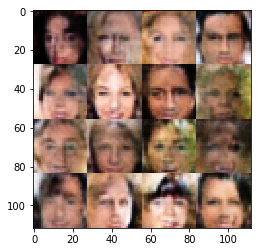

Epoch 2/10... 60.68%... Discriminator Loss: 0.6834... Generator Loss: 1.3871
Epoch 2/10... 61.63%... Discriminator Loss: 0.8471... Generator Loss: 1.4474
Epoch 2/10... 62.58%... Discriminator Loss: 1.2239... Generator Loss: 1.9412
Epoch 2/10... 63.53%... Discriminator Loss: 0.8230... Generator Loss: 1.5351
Epoch 2/10... 64.48%... Discriminator Loss: 0.9872... Generator Loss: 2.0881
Epoch 2/10... 65.42%... Discriminator Loss: 0.7548... Generator Loss: 1.8623
Epoch 2/10... 66.37%... Discriminator Loss: 0.7665... Generator Loss: 1.7443
Epoch 2/10... 67.32%... Discriminator Loss: 0.8560... Generator Loss: 1.1977
Epoch 2/10... 68.27%... Discriminator Loss: 1.1821... Generator Loss: 0.7011
Epoch 2/10... 69.22%... Discriminator Loss: 0.7844... Generator Loss: 1.2708
Epoch 2/10... 70.16%... Discriminator Loss: 0.7611... Generator Loss: 1.5734
Epoch 2/10... 71.11%... Discriminator Loss: 0.8676... Generator Loss: 1.0437
Epoch 2/10... 72.06%... Discriminator Loss: 1.1467... Generator Loss: 1.2616

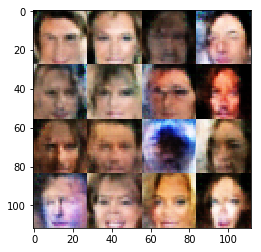

Epoch 2/10... 80.59%... Discriminator Loss: 0.9722... Generator Loss: 1.1722
Epoch 2/10... 81.54%... Discriminator Loss: 0.9455... Generator Loss: 2.2957
Epoch 2/10... 82.49%... Discriminator Loss: 0.8272... Generator Loss: 1.1312
Epoch 2/10... 83.44%... Discriminator Loss: 0.8770... Generator Loss: 1.2282
Epoch 2/10... 84.39%... Discriminator Loss: 1.4744... Generator Loss: 0.3850
Epoch 2/10... 85.34%... Discriminator Loss: 0.8818... Generator Loss: 1.2760
Epoch 2/10... 86.28%... Discriminator Loss: 0.8545... Generator Loss: 2.3509
Epoch 2/10... 87.23%... Discriminator Loss: 0.8823... Generator Loss: 1.4607
Epoch 2/10... 88.18%... Discriminator Loss: 0.7662... Generator Loss: 1.4296
Epoch 2/10... 89.13%... Discriminator Loss: 0.9893... Generator Loss: 1.1048
Epoch 2/10... 90.08%... Discriminator Loss: 1.1048... Generator Loss: 1.1150
Epoch 2/10... 91.02%... Discriminator Loss: 0.7491... Generator Loss: 2.1103
Epoch 2/10... 91.97%... Discriminator Loss: 0.6345... Generator Loss: 1.1757

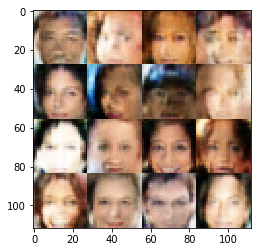

Epoch 3/10... 0.95%... Discriminator Loss: 0.9234... Generator Loss: 1.3267
Epoch 3/10... 1.90%... Discriminator Loss: 0.9621... Generator Loss: 0.9793
Epoch 3/10... 2.84%... Discriminator Loss: 1.1747... Generator Loss: 0.7070
Epoch 3/10... 3.79%... Discriminator Loss: 1.0625... Generator Loss: 0.7962
Epoch 3/10... 4.74%... Discriminator Loss: 1.1450... Generator Loss: 0.6256
Epoch 3/10... 5.69%... Discriminator Loss: 1.0170... Generator Loss: 0.9123
Epoch 3/10... 6.64%... Discriminator Loss: 1.0099... Generator Loss: 0.8736
Epoch 3/10... 7.59%... Discriminator Loss: 0.7279... Generator Loss: 1.1706
Epoch 3/10... 8.53%... Discriminator Loss: 1.0353... Generator Loss: 0.7004
Epoch 3/10... 9.48%... Discriminator Loss: 0.7339... Generator Loss: 1.3244
Epoch 3/10... 10.43%... Discriminator Loss: 1.6847... Generator Loss: 0.6547
Epoch 3/10... 11.38%... Discriminator Loss: 0.9260... Generator Loss: 1.1577
Epoch 3/10... 12.33%... Discriminator Loss: 0.9017... Generator Loss: 0.8786
Epoch 3/1

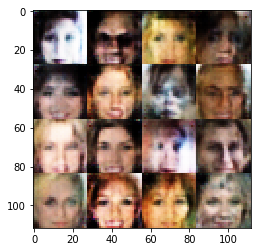

Epoch 3/10... 20.86%... Discriminator Loss: 1.5438... Generator Loss: 0.3800
Epoch 3/10... 21.81%... Discriminator Loss: 1.0011... Generator Loss: 0.8295
Epoch 3/10... 22.76%... Discriminator Loss: 0.9851... Generator Loss: 0.9499
Epoch 3/10... 23.70%... Discriminator Loss: 0.6258... Generator Loss: 2.2385
Epoch 3/10... 24.65%... Discriminator Loss: 1.2992... Generator Loss: 0.6510
Epoch 3/10... 25.60%... Discriminator Loss: 1.1265... Generator Loss: 0.8810
Epoch 3/10... 26.55%... Discriminator Loss: 1.3641... Generator Loss: 0.6053
Epoch 3/10... 27.50%... Discriminator Loss: 0.4983... Generator Loss: 1.5191
Epoch 3/10... 28.45%... Discriminator Loss: 0.4459... Generator Loss: 2.2095
Epoch 3/10... 29.39%... Discriminator Loss: 1.1802... Generator Loss: 0.7735
Epoch 3/10... 30.34%... Discriminator Loss: 1.2817... Generator Loss: 0.9242
Epoch 3/10... 31.29%... Discriminator Loss: 0.8652... Generator Loss: 1.7757
Epoch 3/10... 32.24%... Discriminator Loss: 1.2177... Generator Loss: 1.2025

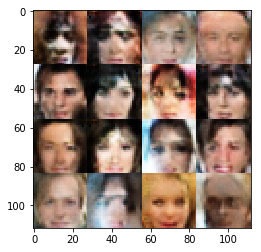

Epoch 3/10... 40.77%... Discriminator Loss: 1.0239... Generator Loss: 0.7960
Epoch 3/10... 41.72%... Discriminator Loss: 1.3283... Generator Loss: 0.4729
Epoch 3/10... 42.67%... Discriminator Loss: 0.8026... Generator Loss: 1.2589
Epoch 3/10... 43.62%... Discriminator Loss: 1.0660... Generator Loss: 0.8467
Epoch 3/10... 44.56%... Discriminator Loss: 0.5587... Generator Loss: 2.1876
Epoch 3/10... 45.51%... Discriminator Loss: 0.9819... Generator Loss: 0.9275
Epoch 3/10... 46.46%... Discriminator Loss: 0.8492... Generator Loss: 1.1253
Epoch 3/10... 47.41%... Discriminator Loss: 0.8198... Generator Loss: 1.0558
Epoch 3/10... 48.36%... Discriminator Loss: 0.9371... Generator Loss: 1.1722
Epoch 3/10... 49.30%... Discriminator Loss: 0.6334... Generator Loss: 1.7680
Epoch 3/10... 50.25%... Discriminator Loss: 0.7666... Generator Loss: 1.3374
Epoch 3/10... 51.20%... Discriminator Loss: 0.4828... Generator Loss: 1.6768
Epoch 3/10... 52.15%... Discriminator Loss: 0.8385... Generator Loss: 1.0736

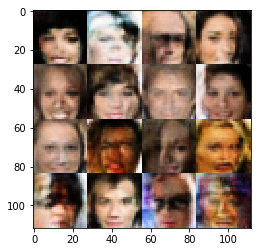

Epoch 3/10... 60.68%... Discriminator Loss: 0.5947... Generator Loss: 1.7836
Epoch 3/10... 61.63%... Discriminator Loss: 1.1190... Generator Loss: 0.6192
Epoch 3/10... 62.58%... Discriminator Loss: 1.0041... Generator Loss: 0.7721
Epoch 3/10... 63.53%... Discriminator Loss: 0.7350... Generator Loss: 1.0787
Epoch 3/10... 64.48%... Discriminator Loss: 0.6404... Generator Loss: 2.9502
Epoch 3/10... 65.42%... Discriminator Loss: 0.7996... Generator Loss: 1.0518
Epoch 3/10... 66.37%... Discriminator Loss: 0.3916... Generator Loss: 2.3639
Epoch 3/10... 67.32%... Discriminator Loss: 0.4846... Generator Loss: 1.4796
Epoch 3/10... 68.27%... Discriminator Loss: 0.9642... Generator Loss: 1.0255
Epoch 3/10... 69.22%... Discriminator Loss: 0.8848... Generator Loss: 0.8253
Epoch 3/10... 70.16%... Discriminator Loss: 0.6211... Generator Loss: 1.2054
Epoch 3/10... 71.11%... Discriminator Loss: 0.7553... Generator Loss: 0.9791
Epoch 3/10... 72.06%... Discriminator Loss: 0.5694... Generator Loss: 2.1309

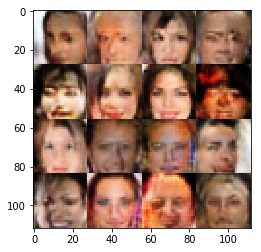

Epoch 3/10... 80.59%... Discriminator Loss: 0.6622... Generator Loss: 1.3969
Epoch 3/10... 81.54%... Discriminator Loss: 0.7023... Generator Loss: 1.7355
Epoch 3/10... 82.49%... Discriminator Loss: 0.6120... Generator Loss: 1.2143
Epoch 3/10... 83.44%... Discriminator Loss: 0.7467... Generator Loss: 1.5787
Epoch 3/10... 84.39%... Discriminator Loss: 1.2720... Generator Loss: 0.4738
Epoch 3/10... 85.34%... Discriminator Loss: 0.7059... Generator Loss: 1.8342
Epoch 3/10... 86.28%... Discriminator Loss: 1.0011... Generator Loss: 0.7666
Epoch 3/10... 87.23%... Discriminator Loss: 0.3799... Generator Loss: 2.5128
Epoch 3/10... 88.18%... Discriminator Loss: 0.5474... Generator Loss: 1.4925
Epoch 3/10... 89.13%... Discriminator Loss: 1.1821... Generator Loss: 0.4907
Epoch 3/10... 90.08%... Discriminator Loss: 0.1639... Generator Loss: 3.1598
Epoch 3/10... 91.02%... Discriminator Loss: 0.2533... Generator Loss: 2.1986
Epoch 3/10... 91.97%... Discriminator Loss: 0.3051... Generator Loss: 2.8653

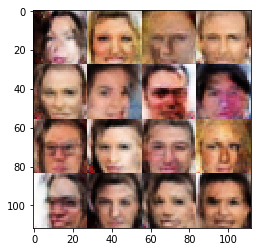

Epoch 4/10... 0.95%... Discriminator Loss: 0.6207... Generator Loss: 1.8736
Epoch 4/10... 1.90%... Discriminator Loss: 0.5723... Generator Loss: 1.2785
Epoch 4/10... 2.84%... Discriminator Loss: 0.9845... Generator Loss: 0.8705
Epoch 4/10... 3.79%... Discriminator Loss: 0.6444... Generator Loss: 1.4977
Epoch 4/10... 4.74%... Discriminator Loss: 1.1211... Generator Loss: 1.9182
Epoch 4/10... 5.69%... Discriminator Loss: 0.7814... Generator Loss: 1.4445
Epoch 4/10... 6.64%... Discriminator Loss: 0.5746... Generator Loss: 1.9235
Epoch 4/10... 7.59%... Discriminator Loss: 1.1312... Generator Loss: 0.8463
Epoch 4/10... 8.53%... Discriminator Loss: 0.6938... Generator Loss: 1.3476
Epoch 4/10... 9.48%... Discriminator Loss: 0.6430... Generator Loss: 1.1089
Epoch 4/10... 10.43%... Discriminator Loss: 0.7078... Generator Loss: 1.8670
Epoch 4/10... 11.38%... Discriminator Loss: 0.5176... Generator Loss: 2.0549
Epoch 4/10... 12.33%... Discriminator Loss: 0.8640... Generator Loss: 0.9735
Epoch 4/1

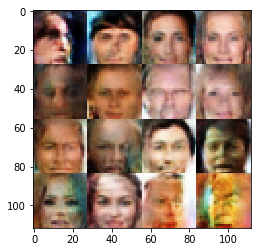

Epoch 4/10... 20.86%... Discriminator Loss: 0.5157... Generator Loss: 2.1606
Epoch 4/10... 21.81%... Discriminator Loss: 0.7410... Generator Loss: 0.8706
Epoch 4/10... 22.76%... Discriminator Loss: 0.7771... Generator Loss: 0.9888
Epoch 4/10... 23.70%... Discriminator Loss: 0.4369... Generator Loss: 1.8850
Epoch 4/10... 24.65%... Discriminator Loss: 1.1270... Generator Loss: 0.5875
Epoch 4/10... 25.60%... Discriminator Loss: 0.6752... Generator Loss: 1.1344
Epoch 4/10... 26.55%... Discriminator Loss: 0.4780... Generator Loss: 1.4875
Epoch 4/10... 27.50%... Discriminator Loss: 0.6301... Generator Loss: 1.3964
Epoch 4/10... 28.45%... Discriminator Loss: 0.2639... Generator Loss: 2.6136
Epoch 4/10... 29.39%... Discriminator Loss: 0.7789... Generator Loss: 0.8943
Epoch 4/10... 30.34%... Discriminator Loss: 0.1567... Generator Loss: 5.6095
Epoch 4/10... 31.29%... Discriminator Loss: 0.2844... Generator Loss: 2.9567
Epoch 4/10... 32.24%... Discriminator Loss: 0.7688... Generator Loss: 0.9669

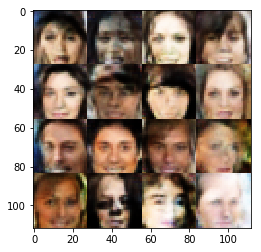

Epoch 4/10... 40.77%... Discriminator Loss: 0.6078... Generator Loss: 2.5520
Epoch 4/10... 41.72%... Discriminator Loss: 0.6769... Generator Loss: 1.1102
Epoch 4/10... 42.67%... Discriminator Loss: 0.6592... Generator Loss: 1.2826
Epoch 4/10... 43.62%... Discriminator Loss: 1.0565... Generator Loss: 0.5782
Epoch 4/10... 44.56%... Discriminator Loss: 0.4377... Generator Loss: 3.1748
Epoch 4/10... 45.51%... Discriminator Loss: 0.3679... Generator Loss: 4.1020
Epoch 4/10... 46.46%... Discriminator Loss: 0.8766... Generator Loss: 0.8759
Epoch 4/10... 47.41%... Discriminator Loss: 0.8440... Generator Loss: 0.7935
Epoch 4/10... 48.36%... Discriminator Loss: 0.5341... Generator Loss: 1.4153
Epoch 4/10... 49.30%... Discriminator Loss: 0.5471... Generator Loss: 1.2662
Epoch 4/10... 50.25%... Discriminator Loss: 0.4199... Generator Loss: 1.7646
Epoch 4/10... 51.20%... Discriminator Loss: 0.7203... Generator Loss: 0.9292
Epoch 4/10... 52.15%... Discriminator Loss: 0.5275... Generator Loss: 1.4564

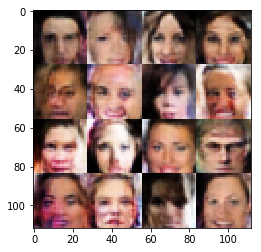

Epoch 4/10... 60.68%... Discriminator Loss: 0.4224... Generator Loss: 1.7467
Epoch 4/10... 61.63%... Discriminator Loss: 1.4980... Generator Loss: 0.3579
Epoch 4/10... 62.58%... Discriminator Loss: 0.2454... Generator Loss: 4.4888
Epoch 4/10... 63.53%... Discriminator Loss: 0.5345... Generator Loss: 1.6891
Epoch 4/10... 64.48%... Discriminator Loss: 0.3445... Generator Loss: 1.8560
Epoch 4/10... 65.42%... Discriminator Loss: 0.5656... Generator Loss: 2.2508
Epoch 4/10... 66.37%... Discriminator Loss: 0.6043... Generator Loss: 1.3225
Epoch 4/10... 67.32%... Discriminator Loss: 0.4922... Generator Loss: 1.4815
Epoch 4/10... 68.27%... Discriminator Loss: 0.3821... Generator Loss: 2.2841
Epoch 4/10... 69.22%... Discriminator Loss: 0.9105... Generator Loss: 0.7263
Epoch 4/10... 70.16%... Discriminator Loss: 0.5196... Generator Loss: 1.4911
Epoch 4/10... 71.11%... Discriminator Loss: 0.3624... Generator Loss: 3.8149
Epoch 4/10... 72.06%... Discriminator Loss: 1.0562... Generator Loss: 0.5986

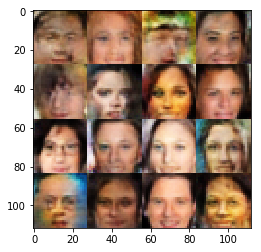

Epoch 4/10... 80.59%... Discriminator Loss: 0.6102... Generator Loss: 1.6031
Epoch 4/10... 81.54%... Discriminator Loss: 1.5315... Generator Loss: 0.3630
Epoch 4/10... 82.49%... Discriminator Loss: 0.5945... Generator Loss: 1.5955
Epoch 4/10... 83.44%... Discriminator Loss: 0.8794... Generator Loss: 1.6416
Epoch 4/10... 84.39%... Discriminator Loss: 1.0180... Generator Loss: 0.9916
Epoch 4/10... 85.34%... Discriminator Loss: 0.7412... Generator Loss: 1.7657
Epoch 4/10... 86.28%... Discriminator Loss: 0.9924... Generator Loss: 2.1355
Epoch 4/10... 87.23%... Discriminator Loss: 0.9698... Generator Loss: 0.7302
Epoch 4/10... 88.18%... Discriminator Loss: 0.8523... Generator Loss: 0.8933
Epoch 4/10... 89.13%... Discriminator Loss: 0.7000... Generator Loss: 1.2194
Epoch 4/10... 90.08%... Discriminator Loss: 0.4359... Generator Loss: 2.3316
Epoch 4/10... 91.02%... Discriminator Loss: 0.4044... Generator Loss: 1.7809
Epoch 4/10... 91.97%... Discriminator Loss: 0.6876... Generator Loss: 1.1141

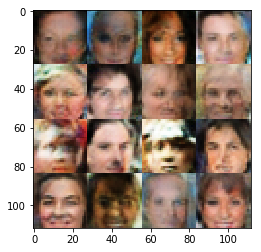

Epoch 5/10... 0.95%... Discriminator Loss: 0.8542... Generator Loss: 1.3185
Epoch 5/10... 1.90%... Discriminator Loss: 0.5358... Generator Loss: 2.0938
Epoch 5/10... 2.84%... Discriminator Loss: 0.6449... Generator Loss: 3.0611
Epoch 5/10... 3.79%... Discriminator Loss: 0.6581... Generator Loss: 1.5189
Epoch 5/10... 4.74%... Discriminator Loss: 0.7113... Generator Loss: 1.1474
Epoch 5/10... 5.69%... Discriminator Loss: 1.0359... Generator Loss: 0.6428
Epoch 5/10... 6.64%... Discriminator Loss: 0.5567... Generator Loss: 1.3677
Epoch 5/10... 7.59%... Discriminator Loss: 1.1705... Generator Loss: 0.5988
Epoch 5/10... 8.53%... Discriminator Loss: 0.5162... Generator Loss: 1.5662
Epoch 5/10... 9.48%... Discriminator Loss: 0.4987... Generator Loss: 1.3997
Epoch 5/10... 10.43%... Discriminator Loss: 0.9590... Generator Loss: 0.9551
Epoch 5/10... 11.38%... Discriminator Loss: 0.6510... Generator Loss: 1.6095
Epoch 5/10... 12.33%... Discriminator Loss: 0.7130... Generator Loss: 1.3725
Epoch 5/1

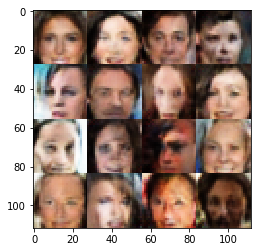

Epoch 5/10... 20.86%... Discriminator Loss: 1.0248... Generator Loss: 0.7646
Epoch 5/10... 21.81%... Discriminator Loss: 0.7892... Generator Loss: 0.9887
Epoch 5/10... 22.76%... Discriminator Loss: 0.7413... Generator Loss: 1.3036
Epoch 5/10... 23.70%... Discriminator Loss: 0.5334... Generator Loss: 1.4204
Epoch 5/10... 24.65%... Discriminator Loss: 0.5733... Generator Loss: 1.8352
Epoch 5/10... 25.60%... Discriminator Loss: 0.8352... Generator Loss: 0.9329
Epoch 5/10... 26.55%... Discriminator Loss: 0.5798... Generator Loss: 1.2755
Epoch 5/10... 27.50%... Discriminator Loss: 0.5529... Generator Loss: 1.2840
Epoch 5/10... 28.45%... Discriminator Loss: 0.6268... Generator Loss: 1.4869
Epoch 5/10... 29.39%... Discriminator Loss: 0.8166... Generator Loss: 1.2174
Epoch 5/10... 30.34%... Discriminator Loss: 0.7967... Generator Loss: 1.3707
Epoch 5/10... 31.29%... Discriminator Loss: 0.4257... Generator Loss: 1.6358
Epoch 5/10... 32.24%... Discriminator Loss: 0.5158... Generator Loss: 1.4781

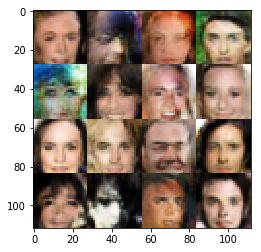

Epoch 5/10... 40.77%... Discriminator Loss: 0.7458... Generator Loss: 1.2139
Epoch 5/10... 41.72%... Discriminator Loss: 1.5203... Generator Loss: 0.3886
Epoch 5/10... 42.67%... Discriminator Loss: 0.9107... Generator Loss: 0.9092
Epoch 5/10... 43.62%... Discriminator Loss: 0.7911... Generator Loss: 1.5611
Epoch 5/10... 44.56%... Discriminator Loss: 0.9340... Generator Loss: 0.9943
Epoch 5/10... 45.51%... Discriminator Loss: 0.4397... Generator Loss: 2.2975
Epoch 5/10... 46.46%... Discriminator Loss: 0.5663... Generator Loss: 1.4864
Epoch 5/10... 47.41%... Discriminator Loss: 0.4924... Generator Loss: 1.4179
Epoch 5/10... 48.36%... Discriminator Loss: 1.2137... Generator Loss: 0.5659
Epoch 5/10... 49.30%... Discriminator Loss: 0.7931... Generator Loss: 0.9852
Epoch 5/10... 50.25%... Discriminator Loss: 0.7291... Generator Loss: 1.1359
Epoch 5/10... 51.20%... Discriminator Loss: 0.7859... Generator Loss: 1.1198
Epoch 5/10... 52.15%... Discriminator Loss: 0.5910... Generator Loss: 1.3748

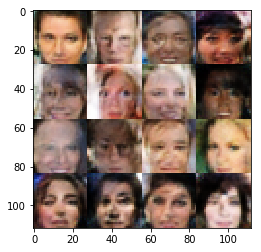

Epoch 5/10... 60.68%... Discriminator Loss: 0.6559... Generator Loss: 1.1629
Epoch 5/10... 61.63%... Discriminator Loss: 0.9584... Generator Loss: 0.8428
Epoch 5/10... 62.58%... Discriminator Loss: 0.6615... Generator Loss: 3.0715
Epoch 5/10... 63.53%... Discriminator Loss: 0.9222... Generator Loss: 0.9093
Epoch 5/10... 64.48%... Discriminator Loss: 0.7455... Generator Loss: 1.1101
Epoch 5/10... 65.42%... Discriminator Loss: 0.3083... Generator Loss: 1.9547
Epoch 5/10... 66.37%... Discriminator Loss: 0.8407... Generator Loss: 0.8437
Epoch 5/10... 67.32%... Discriminator Loss: 0.5275... Generator Loss: 1.5814
Epoch 5/10... 68.27%... Discriminator Loss: 0.8609... Generator Loss: 1.2978
Epoch 5/10... 69.22%... Discriminator Loss: 0.5561... Generator Loss: 1.3855
Epoch 5/10... 70.16%... Discriminator Loss: 0.6230... Generator Loss: 1.9613
Epoch 5/10... 71.11%... Discriminator Loss: 0.6595... Generator Loss: 1.3115
Epoch 5/10... 72.06%... Discriminator Loss: 0.7178... Generator Loss: 1.1161

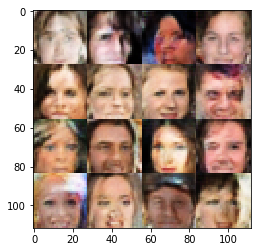

Epoch 5/10... 80.59%... Discriminator Loss: 0.5560... Generator Loss: 2.1951
Epoch 5/10... 81.54%... Discriminator Loss: 0.7659... Generator Loss: 0.9345
Epoch 5/10... 82.49%... Discriminator Loss: 0.9556... Generator Loss: 0.8037
Epoch 5/10... 83.44%... Discriminator Loss: 0.5437... Generator Loss: 2.0875
Epoch 5/10... 84.39%... Discriminator Loss: 0.6098... Generator Loss: 1.7740
Epoch 5/10... 85.34%... Discriminator Loss: 0.5617... Generator Loss: 1.8005
Epoch 5/10... 86.28%... Discriminator Loss: 0.6342... Generator Loss: 3.5424
Epoch 5/10... 87.23%... Discriminator Loss: 0.6477... Generator Loss: 1.1675
Epoch 5/10... 88.18%... Discriminator Loss: 0.8445... Generator Loss: 1.0630
Epoch 5/10... 89.13%... Discriminator Loss: 1.1715... Generator Loss: 0.7066
Epoch 5/10... 90.08%... Discriminator Loss: 0.7098... Generator Loss: 1.6905
Epoch 5/10... 91.02%... Discriminator Loss: 0.7422... Generator Loss: 1.1202
Epoch 5/10... 91.97%... Discriminator Loss: 0.9542... Generator Loss: 0.8097

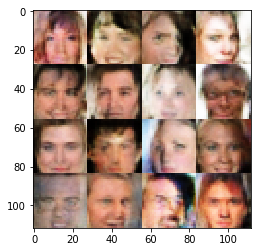

Epoch 6/10... 0.95%... Discriminator Loss: 0.7931... Generator Loss: 1.2755
Epoch 6/10... 1.90%... Discriminator Loss: 0.6798... Generator Loss: 1.3476
Epoch 6/10... 2.84%... Discriminator Loss: 0.7656... Generator Loss: 1.4091
Epoch 6/10... 3.79%... Discriminator Loss: 0.4391... Generator Loss: 1.8681
Epoch 6/10... 4.74%... Discriminator Loss: 0.7172... Generator Loss: 1.2333
Epoch 6/10... 5.69%... Discriminator Loss: 0.6896... Generator Loss: 1.3542
Epoch 6/10... 6.64%... Discriminator Loss: 0.7657... Generator Loss: 0.9833
Epoch 6/10... 7.59%... Discriminator Loss: 0.4317... Generator Loss: 3.7550
Epoch 6/10... 8.53%... Discriminator Loss: 1.1425... Generator Loss: 0.7105
Epoch 6/10... 9.48%... Discriminator Loss: 0.5832... Generator Loss: 1.3141
Epoch 6/10... 10.43%... Discriminator Loss: 0.3796... Generator Loss: 2.1399
Epoch 6/10... 11.38%... Discriminator Loss: 0.7868... Generator Loss: 1.3477
Epoch 6/10... 12.33%... Discriminator Loss: 0.6447... Generator Loss: 2.0912
Epoch 6/1

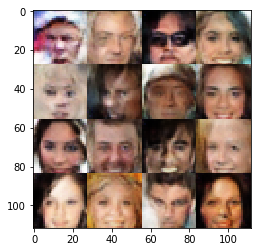

Epoch 6/10... 20.86%... Discriminator Loss: 0.9872... Generator Loss: 0.8037
Epoch 6/10... 21.81%... Discriminator Loss: 0.5415... Generator Loss: 2.0106
Epoch 6/10... 22.76%... Discriminator Loss: 0.9196... Generator Loss: 1.8620
Epoch 6/10... 23.70%... Discriminator Loss: 0.6409... Generator Loss: 1.2338
Epoch 6/10... 24.65%... Discriminator Loss: 0.9171... Generator Loss: 0.8908
Epoch 6/10... 25.60%... Discriminator Loss: 0.8471... Generator Loss: 0.9756
Epoch 6/10... 26.55%... Discriminator Loss: 0.7705... Generator Loss: 1.3154
Epoch 6/10... 27.50%... Discriminator Loss: 0.4497... Generator Loss: 1.7349
Epoch 6/10... 28.45%... Discriminator Loss: 0.5523... Generator Loss: 1.8730
Epoch 6/10... 29.39%... Discriminator Loss: 0.9416... Generator Loss: 0.7304
Epoch 6/10... 30.34%... Discriminator Loss: 0.7792... Generator Loss: 1.0536
Epoch 6/10... 31.29%... Discriminator Loss: 0.8312... Generator Loss: 1.0218
Epoch 6/10... 32.24%... Discriminator Loss: 0.5929... Generator Loss: 1.5558

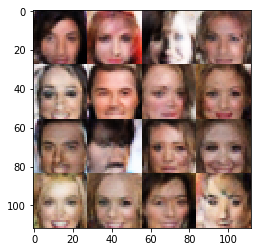

Epoch 6/10... 40.77%... Discriminator Loss: 0.6616... Generator Loss: 1.9020
Epoch 6/10... 41.72%... Discriminator Loss: 0.9097... Generator Loss: 0.7659
Epoch 6/10... 42.67%... Discriminator Loss: 0.9202... Generator Loss: 0.8712
Epoch 6/10... 43.62%... Discriminator Loss: 1.1667... Generator Loss: 0.6349
Epoch 6/10... 44.56%... Discriminator Loss: 0.6995... Generator Loss: 1.0667
Epoch 6/10... 45.51%... Discriminator Loss: 0.5150... Generator Loss: 1.6910
Epoch 6/10... 46.46%... Discriminator Loss: 1.0371... Generator Loss: 1.3678
Epoch 6/10... 47.41%... Discriminator Loss: 0.8652... Generator Loss: 0.9314
Epoch 6/10... 48.36%... Discriminator Loss: 1.0238... Generator Loss: 0.7474
Epoch 6/10... 49.30%... Discriminator Loss: 0.6651... Generator Loss: 1.0565
Epoch 6/10... 50.25%... Discriminator Loss: 1.0605... Generator Loss: 0.6604
Epoch 6/10... 51.20%... Discriminator Loss: 0.5319... Generator Loss: 1.8843
Epoch 6/10... 52.15%... Discriminator Loss: 0.9432... Generator Loss: 0.8406

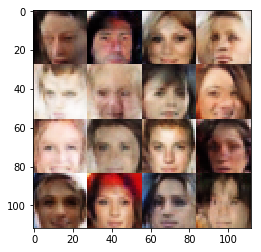

Epoch 6/10... 60.68%... Discriminator Loss: 0.6434... Generator Loss: 1.6768
Epoch 6/10... 61.63%... Discriminator Loss: 0.6192... Generator Loss: 1.5310
Epoch 6/10... 62.58%... Discriminator Loss: 0.5159... Generator Loss: 1.5582
Epoch 6/10... 63.53%... Discriminator Loss: 0.7481... Generator Loss: 1.1615
Epoch 6/10... 64.48%... Discriminator Loss: 0.6412... Generator Loss: 2.4215
Epoch 6/10... 65.42%... Discriminator Loss: 0.5869... Generator Loss: 1.5480
Epoch 6/10... 66.37%... Discriminator Loss: 1.3253... Generator Loss: 0.5721
Epoch 6/10... 67.32%... Discriminator Loss: 0.4229... Generator Loss: 1.6835
Epoch 6/10... 68.27%... Discriminator Loss: 1.0075... Generator Loss: 0.7861
Epoch 6/10... 69.22%... Discriminator Loss: 0.9465... Generator Loss: 0.8244
Epoch 6/10... 70.16%... Discriminator Loss: 0.7547... Generator Loss: 1.2348
Epoch 6/10... 71.11%... Discriminator Loss: 0.6908... Generator Loss: 1.1344
Epoch 6/10... 72.06%... Discriminator Loss: 0.7855... Generator Loss: 1.0491

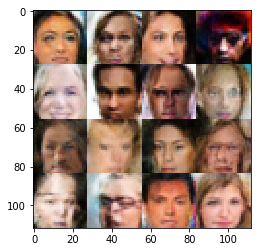

Epoch 6/10... 80.59%... Discriminator Loss: 0.7188... Generator Loss: 1.1720
Epoch 6/10... 81.54%... Discriminator Loss: 0.6427... Generator Loss: 1.4253
Epoch 6/10... 82.49%... Discriminator Loss: 0.7062... Generator Loss: 1.2100
Epoch 6/10... 83.44%... Discriminator Loss: 0.8750... Generator Loss: 0.9160
Epoch 6/10... 84.39%... Discriminator Loss: 0.8262... Generator Loss: 0.9271
Epoch 6/10... 85.34%... Discriminator Loss: 0.6584... Generator Loss: 1.3900
Epoch 6/10... 86.28%... Discriminator Loss: 0.6943... Generator Loss: 1.5070
Epoch 6/10... 87.23%... Discriminator Loss: 0.7926... Generator Loss: 1.0602
Epoch 6/10... 88.18%... Discriminator Loss: 0.8787... Generator Loss: 0.8909
Epoch 6/10... 89.13%... Discriminator Loss: 0.6475... Generator Loss: 1.2621
Epoch 6/10... 90.08%... Discriminator Loss: 0.6548... Generator Loss: 1.3541
Epoch 6/10... 91.02%... Discriminator Loss: 0.7155... Generator Loss: 1.4931
Epoch 6/10... 91.97%... Discriminator Loss: 0.7650... Generator Loss: 1.1517

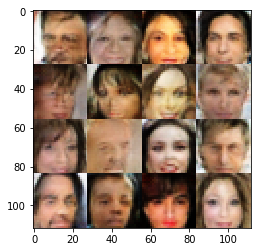

Epoch 7/10... 0.95%... Discriminator Loss: 0.9495... Generator Loss: 0.8076
Epoch 7/10... 1.90%... Discriminator Loss: 0.9072... Generator Loss: 0.8765
Epoch 7/10... 2.84%... Discriminator Loss: 0.9846... Generator Loss: 0.9287
Epoch 7/10... 3.79%... Discriminator Loss: 0.6453... Generator Loss: 1.1322
Epoch 7/10... 4.74%... Discriminator Loss: 0.8312... Generator Loss: 1.5066
Epoch 7/10... 5.69%... Discriminator Loss: 0.8410... Generator Loss: 0.8829
Epoch 7/10... 6.64%... Discriminator Loss: 0.7970... Generator Loss: 1.0276
Epoch 7/10... 7.59%... Discriminator Loss: 0.8087... Generator Loss: 0.9231
Epoch 7/10... 8.53%... Discriminator Loss: 0.7081... Generator Loss: 1.2821
Epoch 7/10... 9.48%... Discriminator Loss: 0.6686... Generator Loss: 2.0659
Epoch 7/10... 10.43%... Discriminator Loss: 0.7051... Generator Loss: 0.9811
Epoch 7/10... 11.38%... Discriminator Loss: 0.5811... Generator Loss: 1.7996
Epoch 7/10... 12.33%... Discriminator Loss: 0.6043... Generator Loss: 1.7611
Epoch 7/1

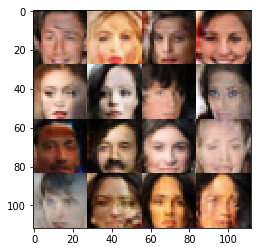

Epoch 7/10... 20.86%... Discriminator Loss: 1.3674... Generator Loss: 0.5394
Epoch 7/10... 21.81%... Discriminator Loss: 0.6090... Generator Loss: 1.1434
Epoch 7/10... 22.76%... Discriminator Loss: 0.7559... Generator Loss: 1.1171
Epoch 7/10... 23.70%... Discriminator Loss: 0.7890... Generator Loss: 0.9778
Epoch 7/10... 24.65%... Discriminator Loss: 1.5249... Generator Loss: 0.4797
Epoch 7/10... 25.60%... Discriminator Loss: 0.7481... Generator Loss: 1.1941
Epoch 7/10... 26.55%... Discriminator Loss: 0.7567... Generator Loss: 2.0300
Epoch 7/10... 27.50%... Discriminator Loss: 0.5480... Generator Loss: 1.5767
Epoch 7/10... 28.45%... Discriminator Loss: 0.6270... Generator Loss: 1.7556
Epoch 7/10... 29.39%... Discriminator Loss: 0.8040... Generator Loss: 1.0014
Epoch 7/10... 30.34%... Discriminator Loss: 0.7098... Generator Loss: 2.1293
Epoch 7/10... 31.29%... Discriminator Loss: 0.9898... Generator Loss: 0.7349
Epoch 7/10... 32.24%... Discriminator Loss: 0.7496... Generator Loss: 1.2602

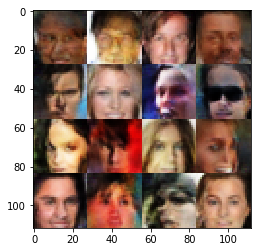

Epoch 7/10... 40.77%... Discriminator Loss: 0.5878... Generator Loss: 1.5721
Epoch 7/10... 41.72%... Discriminator Loss: 1.1635... Generator Loss: 0.5868
Epoch 7/10... 42.67%... Discriminator Loss: 1.3622... Generator Loss: 0.4595
Epoch 7/10... 43.62%... Discriminator Loss: 0.8641... Generator Loss: 0.9504
Epoch 7/10... 44.56%... Discriminator Loss: 0.7441... Generator Loss: 1.5512
Epoch 7/10... 45.51%... Discriminator Loss: 0.8605... Generator Loss: 0.9369
Epoch 7/10... 46.46%... Discriminator Loss: 1.2998... Generator Loss: 0.5621
Epoch 7/10... 47.41%... Discriminator Loss: 0.8978... Generator Loss: 0.8900
Epoch 7/10... 48.36%... Discriminator Loss: 0.6343... Generator Loss: 1.9071
Epoch 7/10... 49.30%... Discriminator Loss: 0.8737... Generator Loss: 0.9273
Epoch 7/10... 50.25%... Discriminator Loss: 0.5573... Generator Loss: 2.1344
Epoch 7/10... 51.20%... Discriminator Loss: 0.8617... Generator Loss: 1.0301
Epoch 7/10... 52.15%... Discriminator Loss: 0.8989... Generator Loss: 0.9364

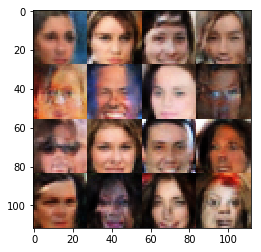

Epoch 7/10... 60.68%... Discriminator Loss: 0.8444... Generator Loss: 0.9064
Epoch 7/10... 61.63%... Discriminator Loss: 0.9338... Generator Loss: 0.8840
Epoch 7/10... 62.58%... Discriminator Loss: 0.6882... Generator Loss: 1.1635
Epoch 7/10... 63.53%... Discriminator Loss: 0.8356... Generator Loss: 1.2600
Epoch 7/10... 64.48%... Discriminator Loss: 0.8026... Generator Loss: 0.9675
Epoch 7/10... 65.42%... Discriminator Loss: 1.0386... Generator Loss: 0.7759
Epoch 7/10... 66.37%... Discriminator Loss: 1.0166... Generator Loss: 0.8613
Epoch 7/10... 67.32%... Discriminator Loss: 0.5551... Generator Loss: 1.4546
Epoch 7/10... 68.27%... Discriminator Loss: 0.6712... Generator Loss: 1.6647
Epoch 7/10... 69.22%... Discriminator Loss: 0.7259... Generator Loss: 1.0922
Epoch 7/10... 70.16%... Discriminator Loss: 0.6836... Generator Loss: 1.3606
Epoch 7/10... 71.11%... Discriminator Loss: 0.9179... Generator Loss: 0.8291
Epoch 7/10... 72.06%... Discriminator Loss: 0.7791... Generator Loss: 1.1619

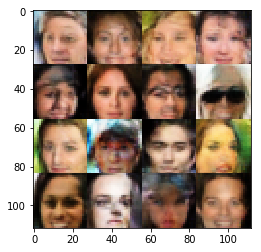

Epoch 7/10... 80.59%... Discriminator Loss: 1.3355... Generator Loss: 1.7645
Epoch 7/10... 81.54%... Discriminator Loss: 1.0244... Generator Loss: 0.7526
Epoch 7/10... 82.49%... Discriminator Loss: 0.6612... Generator Loss: 1.3639
Epoch 7/10... 83.44%... Discriminator Loss: 0.7735... Generator Loss: 0.9643
Epoch 7/10... 84.39%... Discriminator Loss: 0.9262... Generator Loss: 0.8510
Epoch 7/10... 85.34%... Discriminator Loss: 0.8120... Generator Loss: 1.1484
Epoch 7/10... 86.28%... Discriminator Loss: 0.7240... Generator Loss: 1.4605
Epoch 7/10... 87.23%... Discriminator Loss: 0.6509... Generator Loss: 1.3796
Epoch 7/10... 88.18%... Discriminator Loss: 0.9864... Generator Loss: 1.0740
Epoch 7/10... 89.13%... Discriminator Loss: 0.7387... Generator Loss: 1.1151
Epoch 7/10... 90.08%... Discriminator Loss: 0.6803... Generator Loss: 1.4916
Epoch 7/10... 91.02%... Discriminator Loss: 0.7893... Generator Loss: 1.4318
Epoch 7/10... 91.97%... Discriminator Loss: 0.8290... Generator Loss: 1.0149

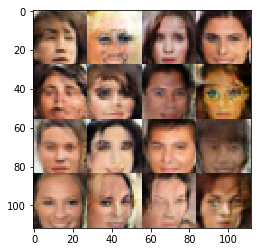

Epoch 8/10... 0.95%... Discriminator Loss: 0.8146... Generator Loss: 0.9029
Epoch 8/10... 1.90%... Discriminator Loss: 0.9941... Generator Loss: 0.7052
Epoch 8/10... 2.84%... Discriminator Loss: 1.2756... Generator Loss: 0.5729
Epoch 8/10... 3.79%... Discriminator Loss: 0.7755... Generator Loss: 1.4748
Epoch 8/10... 4.74%... Discriminator Loss: 0.9211... Generator Loss: 1.7003
Epoch 8/10... 5.69%... Discriminator Loss: 0.9531... Generator Loss: 0.8122
Epoch 8/10... 6.64%... Discriminator Loss: 0.8442... Generator Loss: 1.0645
Epoch 8/10... 7.59%... Discriminator Loss: 0.7832... Generator Loss: 1.2292
Epoch 8/10... 8.53%... Discriminator Loss: 0.8186... Generator Loss: 0.9664
Epoch 8/10... 9.48%... Discriminator Loss: 0.5748... Generator Loss: 1.5780
Epoch 8/10... 10.43%... Discriminator Loss: 0.7041... Generator Loss: 1.0857
Epoch 8/10... 11.38%... Discriminator Loss: 0.7120... Generator Loss: 1.6360
Epoch 8/10... 12.33%... Discriminator Loss: 0.8400... Generator Loss: 1.5105
Epoch 8/1

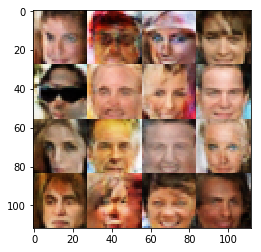

Epoch 8/10... 20.86%... Discriminator Loss: 1.2911... Generator Loss: 0.4704
Epoch 8/10... 21.81%... Discriminator Loss: 0.5927... Generator Loss: 1.2814
Epoch 8/10... 22.76%... Discriminator Loss: 0.8064... Generator Loss: 1.2581


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.